In [1]:
from build_gen_train_file import *
from matplotlib import pyplot as plt

In [2]:
with open('constraint_dict.json', 'r') as infile:
    CONSTRAINT_JSON = json.load(infile)
    
a = CONSTRAINT_JSON['the PERSON PERFORMING BEHAVIOR\'s attribute']
e = CONSTRAINT_JSON['the environment']
attribute_constraints = [c for b in a for c in a[b] if b != 'country']
environment_constraints = [c for b in e for c in e[b]] + [c for b in a for c in a[b] if b == 'country']
len(attribute_constraints), len(environment_constraints)

(578, 404)

In [3]:
SEED = 7
TRAIN_SIZE = 0.8
DEV_SIZE = 0.1

CATEGORIES = {"the PERSON PERFORMING BEHAVIOR's attribute": "attr",
         "the PERSON PERFORMING BEHAVIOR is also doing": 'behav',
         "the PERSON PERFORMING BEHAVIOR's role": 'role',
         "the environment": 'env',
         "some OTHER PERSON's attribute": "attr (other)",
         "some OTHER PERSON's role": "role (other)"}

In [4]:
random.seed(SEED)

In [5]:
df = pd.concat([pd.read_csv(fn, low_memory=False) for fn in glob('../hit/output/Full*.csv')])
df = df[df['RejectionTime'].isna()].copy()
df = manual_pre_data_filtering(df)

In [6]:
all_constraint_sets = []
all_constraints = set()
for _, row in df.sample(frac=1, random_state=0).iterrows():
    CS = ConstraintSet({})
    try:
        CS.from_mturk(row)
        all_constraint_sets.append(CS)
        for table_name in CS.tables:
            for CT in CS.tables[table_name]:
                all_constraints.update(set([str(c.category) for c in CT.constraints]))
                all_constraints.update(set([str(c.name) for c in CT.constraints]))
                all_constraints.update(set([str(c.relation) for c in CT.constraints]))
                all_constraints.update(set([str(c.value) for c in CT.constraints]))
    except Exception as e:
        print(e)

('Incompatible Constraints:', "[PERSON]'s role is 'ground crew'", "[PERSON]'s role is 'baggage handler'")
('Incompatible Constraints:', "[PERSON]'s role is 'customer'", "[PERSON]'s role is 'pharmacist'")
matched the PERSON PERFORMING BHAVIOR's role with the PERSON PERFORMING BEHAVIOR's role
('Incompatible Constraints:', "[PERSON]'s role is 'massage therapist'", "[PERSON]'s role is not 'massage therapist'")
('Incompatible Constraints:', "[PERSON]'s gender is 'man'", "[PERSON]'s gender is 'woman'")
matched the environment­ with the environment
matched the environment­ with the environment
matched the environment­ with the environment
('Incompatible Constraints:', "[PERSON]'s role is 'the passenger'", "[PERSON]'s role is not 'the passenger'")
('Incompatible Constraints:', "[PERSON]'s gender is 'man'", "[PERSON]'s gender is 'woman'")
('Incompatible Constraints:', "[PERSON]'s role is 'clown'", "[PERSON]'s role is not 'clown'")
('Incompatible Constraints:', "[PERSON]'s role is 'navigator'", 

('Incompatible Constraints:', "[PERSON]'s role is 'student'", "[PERSON]'s role is not 'student'")
('Incompatible Constraints:', "[PERSON]'s role is 'pilot'", "[PERSON]'s role is not 'pilot'")
('Incompatible Constraints:', "[PERSON]'s role is 'kitchen staff'", "[PERSON]'s role is not 'kitchen staff'")
('Incompatible Constraints:', "[OTHER]'s role is 'officer'", "[OTHER]'s role is 'arrestee'")
('Incompatible Constraints:', "[PERSON]'s age bracket is 'infant'", "[PERSON]'s age bracket is 'toddler'")
('Incompatible Constraints:', "[OTHER]'s role is 'sous chef'", "[OTHER]'s role is 'dishwasher'")
('Incompatible Constraints:', "[PERSON]'s role is 'planter'", "[PERSON]'s role is 'gardener'")
('Incompatible Constraints:', "[PERSON]'s age bracket is 'senior citizen'", "[PERSON]'s age bracket is not 'senior citizen'")
matched the enviroment with the environment
matched the enviroment with the environment
('Incompatible Constraints:', "[PERSON]'s role is 'tattoo artist'", "[PERSON]'s role is not 

('Incompatible Constraints:', "[PERSON]'s role is 'spectator'", "[PERSON]'s role is not 'spectator'")
('Incompatible Constraints:', "[PERSON]'s gender is 'man'", "[PERSON]'s gender is 'woman'")
('Incompatible Constraints:', "[PERSON]'s gender is 'woman'", "[PERSON]'s gender is 'man'")
('Incompatible Constraints:', "[PERSON]'s role is 'passenger'", "[PERSON]'s role is not 'passenger'")
('Incompatible Constraints:', "[PERSON]'s gender is 'man'", "[PERSON]'s gender is 'woman'")
('Incompatible Constraints:', "[PERSON]'s age bracket is 'preschooler'", "[PERSON]'s age bracket is not 'preschooler'")
('Incompatible Constraints:', "[PERSON]'s age bracket is 'toddler'", "[PERSON]'s age bracket is 'preschooler'")
('Incompatible Constraints:', "[PERSON]'s age bracket is 'middle-aged adult'", "[PERSON]'s age bracket is 'gradeschooler'")
('Incompatible Constraints:', "[PERSON]'s role is 'personal trainer'", "[PERSON]'s role is not 'personal trainer'")
('Incompatible Constraints:', "[OTHER]'s role is

In [7]:
stats_fine = {}
stats = {}
unique_constraints = set()
i = 0
j = 0
for CS in all_constraint_sets:
    for table_name in CS.tables:
        for table in CS.tables[table_name]:
            stat = Counter([c.category for c in table.constraints])
            stat['setting'] = CS.setting
            stat['behavior'] = CS.behavior
            stat["setting-behavior"] = f"{stat['setting']} [BEHAVIOR] {stat['behavior']}"            
            stat['norm'] = table_name
            stat['worker_id'] = CS.worker_id
            stat['submit_time'] = CS.metadata['SubmitTime']
            
            for level in ['category', 'name', 'relation', 'value']:
                stat[f'preset_{level}'] = 0
                
            for constraint in table:
                stat_fine = stat.copy()
                stat_fine['category'] = constraint.category
                stat_fine['name'] = constraint.name
                stat_fine['relation'] = constraint.relation
                stat_fine['value'] = constraint.value
                
                for level in ['category', 'name', 'relation', 'value']:
                    stat_fine[f'preset_{level}'] = constraint.is_preset(level)
                
                stats_fine[j] = stat_fine
                j+=1
                
            for constraint in table:
                for level in ['category', 'name', 'relation', 'value']:
                    if constraint.is_preset(level):
                        stat[f'preset_{level}'] += 1
            
            stat['constraints'] = str(table)
            stat['string_length'] = len(str(table))
            stat['num_constraints'] = len(table)
            stat["label"] = LABEL_MAPPING[table_name]
            
            
            stat['dummy'] = 1
            stats[i] = stat
            
            unique_constraints.update(set([str(c) for c in table.constraints]))
            i+=1

In [8]:
stats_df = pd.DataFrame.from_dict(stats).T
stats_df = manual_post_data_filtering(stats_df)
stats_df['submit_time'] = pd.to_datetime(stats_df['submit_time'])
stats_df_mean = stats_df.mean()

stats_fine_df = pd.DataFrame.from_dict(stats_fine).T

/Users/cziems/anaconda3/envs/normbank/lib/python3.7/site-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/cziems/anaconda3/envs/normbank/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.
/Users/cziems/anaconda3/envs/normbank/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [28]:
print(f"There are {len(set(stats_df['worker_id'].values))} unique workers")
print(f"The average number of tables per worker is {stats_df.groupby('worker_id').count()['dummy'].mean()}")
print(f"There are {len(all_constraints):,} accepted HITs")
print("")
print(f"There are {stats_df['num_constraints'].sum():,} total annotated constraints (\\numAnnotatedConstraints)")
for category in CJSON_EXP[0]:
    print(f"\t{stats_df[category].sum():,} of them have the category {category}")
print(f"There are {len(unique_constraints):,} unique constraints (\\numUniqueConstraints)")
print(f"There are {len(stats_df):,} total annotated norms (\\numAnnotatedNorms)")
print(f"There are {len(set(stats_df['constraints'].values)):,} unique constraint conjunctions (\\numUniqueConjunctions)")
    
print("")
avg_const = stats_df.groupby(['setting', 'behavior', 'norm']).count()['dummy'].mean()
print(f"The average number of constraints per (norm, setting, behavior) is {avg_const}")
print(f"The average string length of a constraint table is {stats_df_mean['string_length']:.2f} characters")
print(f"The average length of a constraint table is {stats_df_mean['num_constraints']:.2f} constraints")
for preset in ['preset_category', 'preset_name', 'preset_relation', 'preset_value']:
    pct = stats_df[preset].sum() / stats_df['num_constraints'].sum()
    print(f"\t{100*pct:.2f}% of constraints use a {preset}")
    
    

There are 37 unique workers
The average number of tables per worker is 4200.621621621622
There are 53,287 accepted HITs

There are 408,407 total annotated constraints (\numAnnotatedConstraints)
	63,425 of them have the category the environment
	107,564 of them have the category the PERSON PERFORMING BEHAVIOR's role
	9,316 of them have the category some OTHER PERSON's role
	141,988 of them have the category the PERSON PERFORMING BEHAVIOR's attribute
	12,674 of them have the category some OTHER PERSON's attribute
	67,423 of them have the category the PERSON PERFORMING BEHAVIOR is also doing
There are 62,581 unique constraints (\numUniqueConstraints)
There are 155,423 total annotated norms (\numAnnotatedNorms)
There are 70,215 unique constraint conjunctions (\numUniqueConjunctions)

The average number of constraints per (norm, setting, behavior) is 4.235305338311034
The average string length of a constraint table is 114.80 characters
The average length of a constraint table is 2.63 constr

In [10]:
s=set([f"{row['setting-behavior']}-{row['norm']}-{row['constraints']}" for _, row in stats_df.iterrows()])
len(s)

123134

In [12]:
len(set(stats_df['behavior']))

6938

In [13]:
len(set(stats_df['setting']))

129

In [14]:
len(stats_df)

155423

In [15]:
for cat in list(CJSON_EXP[0]):
    consider = stats_fine_df[stats_fine_df['category']==cat]
    pct = len(consider[consider['preset_value']==False])/len(consider)
    print(f"{cat}\t{100*pct:.2f}")

the environment	26.61
the PERSON PERFORMING BEHAVIOR's role	9.29
some OTHER PERSON's role	26.44
the PERSON PERFORMING BEHAVIOR's attribute	32.61
some OTHER PERSON's attribute	55.05
the PERSON PERFORMING BEHAVIOR is also doing	59.06


In [16]:
for cat in list(CJSON_EXP[0]):
    consider = stats_fine_df[stats_fine_df['category']==cat]
    pct = len(consider[consider['preset_value']==True])/len(consider)
    print(f"{cat}\t{100*pct:.2f}")

the environment	73.39
the PERSON PERFORMING BEHAVIOR's role	90.71
some OTHER PERSON's role	73.56
the PERSON PERFORMING BEHAVIOR's attribute	67.39
some OTHER PERSON's attribute	44.95
the PERSON PERFORMING BEHAVIOR is also doing	40.94


In [17]:
consider = stats_fine_df[(stats_fine_df['category']=="some OTHER PERSON's attribute") & \
                         (stats_fine_df['preset_value']==False) ].copy()
Counter(consider['value'].values).most_common()

[('significant other', 266),
 ('adult', 197),
 ('sexually attractive', 146),
 ('child', 128),
 ('romantic partner', 92),
 ('friend', 85),
 ('hungry', 81),
 ('sexuality attractive', 72),
 ('attractive', 72),
 ('family', 71),
 ('interested', 58),
 ('close friend', 58),
 ('older teen', 58),
 ('pregnant', 57),
 ('scared', 54),
 ('told a joke', 53),
 ('learning', 45),
 ('spouse', 45),
 ('receptive', 45),
 ('platonic', 45),
 ('belligerently drunk', 45),
 ('parent', 43),
 ('funny', 42),
 ('young child', 41),
 ('willing', 39),
 ('annoyed', 37),
 ('hard of hearing', 37),
 ('your spouse', 37),
 ('active', 37),
 ('gravely injured', 35),
 ('helpful', 34),
 ('had accident', 34),
 ('committed suicide in area', 32),
 ('famous', 31),
 ('confused', 31),
 ('offended', 30),
 ('horny', 30),
 ('spouse of the person performing the behavior', 28),
 ('willing to talk', 28),
 ('gradeschooler or younger', 27),
 ('sexual partner', 27),
 ('consenting', 26),
 ('son of the person performing the behavior', 25),
 ('y

In [18]:
set(consider[consider['value']=='adult']['relation'])

{'is', 'is less than', 'is not'}

In [19]:
# consider = stats_df[stats_df['preset_category']<stats_df['num_constraints']].copy()
# list(consider['constraints'].values)

In [20]:
# consider[consider['constraints']=="[PERSON]'s gender is 'man' [AND] [PERSON]'s behavior is 'be in loud or flashing environments' [AND] [PERSON]'s behavior is 'choose to go on a particular ride' [AND] [PERSON]'s behavior is 'get in line' [AND] [PERSON]'s behavior is 'hold hands with someone' [AND] [PERSON]'s behavior is 'put your hands up' [AND] [PERSON]'s behavior is 'scream' [AND] [PERSON]'s behavior is 'wear a safety harness' [AND] Send some OTHER PERSON's attribute children is 'has young children'"]

In [21]:
len(set(stats_df['setting']))

129

In [22]:
SPLITS_df = add_split_col_and_shuffle(stats_df, 
                                      no_bleeding='setting-behavior', 
                                      train_frac=TRAIN_SIZE, 
                                      dev_frac=DEV_SIZE)

In [25]:
header = "& \\textsc{total constr.} & \\textsc{total conj.} & \\textsc{unique conj.} & \\textsc{constr. / conj.}"
for m in ['Tax: Name', 'Tax: Val']:
    header += f" &\\textsc{{{m}}}"    
# for CAT in CATEGORIES:
#     header += f" & \#\\textsc{{{CATEGORIES[CAT]}}}"
header += "\\\\ \\midrule"
print(header)

for splt in ['train', 'dev', 'test']:
    consider = SPLITS_df[SPLITS_df['split']==splt].copy()
    outstr = f"\\texttt{{{splt}}} & {consider['num_constraints'].sum():,}"
    outstr += f" & {len(consider):,} & {len(set(consider['constraints'].values)):,}"
    outstr += f" & {consider['num_constraints'].mean():.2f}"
    
    for preset in ['preset_name', 'preset_value']:
        pct = 100*consider[preset].sum() / consider['num_constraints'].sum()
        outstr += f" & {pct:.1f}\\%"
        
    outstr += "\\\\"
    print(outstr, end='\n' if splt!='test' else '\\hline \n')
    
    
consider = SPLITS_df.copy()
outstr = f"\\textbf{{\data{{}}}} & {consider['num_constraints'].sum():,}"
outstr += f" & {len(consider):,} & {len(set(consider['constraints'].values)):,}"
outstr += f" & {consider['num_constraints'].mean():.2f}"

for preset in ['preset_name', 'preset_value']:
    pct = 100*consider[preset].sum() / consider['num_constraints'].sum()
    outstr += f" & {pct:.1f}\\%"

outstr += "\\\\"
print(outstr)

& \textsc{total constr.} & \textsc{total conj.} & \textsc{unique conj.} & \textsc{constr. / conj.} &\textsc{Tax: Name} &\textsc{Tax: Val}\\ \midrule
\texttt{train} & 328,045 & 124,920 & 57,417 & 2.63 & 93.5\% & 69.3\%\\
\texttt{dev} & 37,761 & 15,008 & 8,573 & 2.52 & 92.8\% & 66.8\%\\
\texttt{test} & 42,601 & 15,495 & 8,674 & 2.75 & 94.6\% & 70.9\%\\\hline 
\textbf{\data{}} & 408,407 & 155,423 & 70,215 & 2.63 & 93.6\% & 69.2\%\\


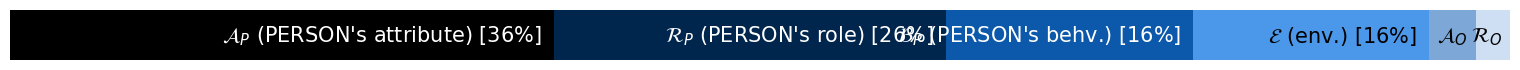

In [30]:
COUNTER = Counter(stats_fine_df['category'])

COLORS = ['#000000','#00264D', '#0C59AB', '#4B98EB', '#7DA7D6', '#CEDFF3']
NAMES = {"the PERSON PERFORMING BEHAVIOR's attribute": "attribute",
         "the PERSON PERFORMING BEHAVIOR's role": 'role',
         "the PERSON PERFORMING BEHAVIOR is also doing": 'behavior',
         "the environment": 'env',
         "some OTHER PERSON's attribute": "attr (other)",
         "some OTHER PERSON's role": "role (other)"}
NAMESL = list(NAMES.values())
NAMESX = [r"$\mathcal{A}_{P}$ (PERSON's attribute)", 
          r"$\mathcal{R}_{P}$ (PERSON's role)", 
          r"$\mathcal{B}_{P}$ (PERSON's behv.)", 
          r"$\mathcal{E}$ (env.)", 
          r"$\mathcal{A}_{O}$", 
          r"$\mathcal{R}_{O}$"]

tot = sum(COUNTER.values())
d = {NAMES[category]: (COUNTER[category]/tot) for category in CJSON_EXP[0]}
ratios = [d[f] for f in NAMESL]
height = .2

plt.rcParams["figure.figsize"] = (15,0.5)
plt.rcParams['image.cmap'] = 'PuRd'


xpos = 0
y_pos = 0
ax = plt.gca()

for j in range(len(ratios)):
    width = ratios[j]
    plt.bar(xpos, height, width, bottom=0, color=COLORS[j], align='edge')
    xpos += width
    
    color = 'black' if j in {3,4,5} else 'white'
    text = f"{NAMESX[j]} [{ratios[j]*100:.0f}%]" if j in {0,1,2,3} else f"{NAMESX[j]}"
    xx = xpos-0.008 if j in {0,1,2,3} else xpos-0.005
    plt.text(xx, 0.07, text, color=color,
             fontsize=15,
             ha='right'
            )

plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('../img/categories.png', dpi=600, bbox_inches='tight')

In [31]:
d

{'env': 0.15514653606130027,
 'role': 0.25797671796565863,
 'role (other)': 0.02251841425551829,
 'attribute': 0.3572090284310839,
 'attr (other)': 0.030528046880049408,
 'behavior': 0.16221780168379427}

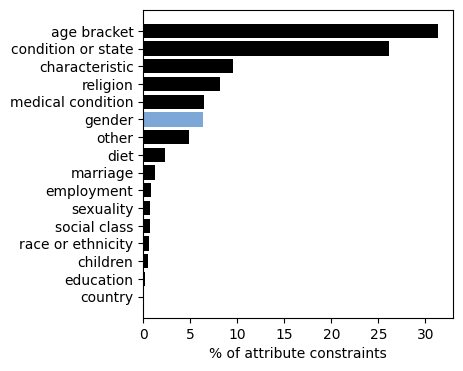

In [32]:
attribute_names = set(CONSTRAINT_JSON["the PERSON PERFORMING BEHAVIOR's attribute"].keys())
COUNTER = Counter([x \
                   if x in attribute_names\
                   else 'other'\
                   for x in stats_fine_df[stats_fine_df['category']=="the PERSON PERFORMING BEHAVIOR's attribute"]['name'].values])

NAMESL = list(dict(COUNTER.most_common()).keys())
COLORS = ['#000000']*len(NAMESL)
COLORS[5] = '#7DA7D6'

tot = sum(COUNTER.values())
d = {key: (COUNTER[key]/tot) for key in NAMESL}

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['image.cmap'] = 'PuRd'
fig, ax = plt.subplots()

y_pos = np.arange(len(d.keys()))
x = [z*100 for z in d.values()]
ax.barh(y_pos, x, align='center', color=COLORS)
ax.set_yticks(y_pos)
ax.set_yticklabels(NAMESL)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of attribute constraints')

plt.show()

In [33]:
d

{'age bracket': 0.31394624153113126,
 'condition or state': 0.2613337086106029,
 'characteristic': 0.09585653686093967,
 'religion': 0.08114700816898199,
 'medical condition': 0.06458789864833168,
 'gender': 0.06362289995510076,
 'other': 0.048363858118386574,
 'diet': 0.022677469290927003,
 'marriage': 0.012900156142149668,
 'employment': 0.008624675820751493,
 'sexuality': 0.007023046045180703,
 'social class': 0.006902421208526835,
 'race or ethnicity': 0.0058570059575266545,
 'children': 0.004831694845968785,
 'education': 0.0019970111846029097,
 'country': 0.0003283676108910825}

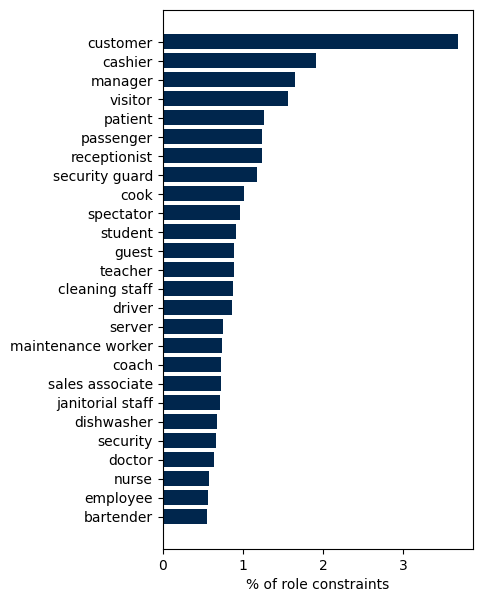

In [34]:
COUNTER = Counter(stats_fine_df[stats_fine_df['category']=="the PERSON PERFORMING BEHAVIOR's role"]['value'].values)

NAMESL = list(dict(COUNTER.most_common(n=26)).keys())
COLORS = ['#00264D']*len(NAMESL)

tot = sum(COUNTER.values())
d = {key: (COUNTER[key]/tot) for key in NAMESL}

plt.rcParams["figure.figsize"] = (4,7)
plt.rcParams['image.cmap'] = 'PuRd'
fig, ax = plt.subplots()

y_pos = np.arange(len(d.keys()))
x = [z*100 for z in d.values()]
ax.barh(y_pos, x, align='center', color=COLORS)
ax.set_yticks(y_pos)
ax.set_yticklabels(NAMESL)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of role constraints')

plt.show()

In [35]:
d

{'customer': 0.03683805175885459,
 'cashier': 0.019161354378346276,
 'manager': 0.016488971782237936,
 'visitor': 0.015607456689771641,
 'patient': 0.012601026269149756,
 'passenger': 0.012461839675602446,
 'receptionist': 0.012406165038183523,
 'security guard': 0.01179374402657536,
 'cook': 0.01011422579777116,
 'spectator': 0.009631712273473819,
 'student': 0.009158477855412966,
 'guest': 0.008898662880791322,
 'teacher': 0.008880104668318348,
 'cleaning staff': 0.008740918074771039,
 'driver': 0.008713080756061576,
 'server': 0.007534634264027689,
 'maintenance worker': 0.0074047267767168665,
 'coach': 0.007302656608115506,
 'sales associate': 0.007237702864460095,
 'janitorial staff': 0.00711707448338576,
 'dishwasher': 0.0068479804025276285,
 'security': 0.006616002746615446,
 'doctor': 0.006448978834358674,
 'nurse': 0.005780883185331589,
 'employee': 0.005678813016730229,
 'bartender': 0.0055953010606018426}

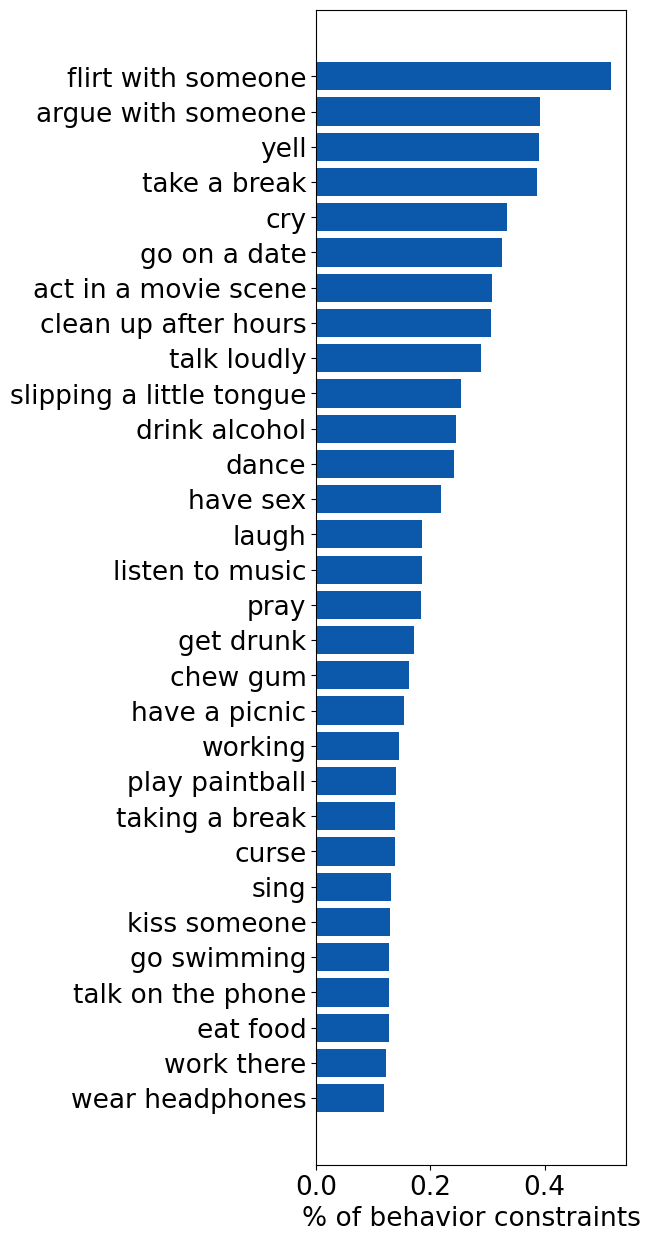

In [41]:
COUNTER = Counter(stats_fine_df[stats_fine_df['category']=="the PERSON PERFORMING BEHAVIOR is also doing"]['value'].values)

NAMESL = list(dict(COUNTER.most_common(n=30)).keys())
COLORS = ['#0C59AB']*len(NAMESL)

tot = sum(COUNTER.values())
d = {key: (COUNTER[key]/tot) for key in NAMESL}

plt.rcParams["figure.figsize"] = (4,15)
plt.rcParams['image.cmap'] = 'PuRd'
plt.rcParams['font.size'] = 19
fig, ax = plt.subplots()

y_pos = np.arange(len(d.keys()))
x = [z*100 for z in d.values()]
ax.barh(y_pos, x, align='center', color=COLORS)
ax.set_yticks(y_pos)
ax.set_yticklabels(NAMESL)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of behavior constraints')

plt.show()

In [42]:
d

{'flirt with someone': 0.005164831921612608,
 'argue with someone': 0.003910515597792403,
 'yell': 0.0038957589351592244,
 'take a break': 0.0038662456098928666,
 'cry': 0.0033350057550984268,
 'go on a date': 0.003246465779299354,
 'act in a movie scene': 0.003084142490334386,
 'clean up after hours': 0.0030546291650680284,
 'talk loudly': 0.0028775492134698816,
 'slipping a little tongue': 0.002538145972906767,
 'drink alcohol': 0.0024496059971076943,
 'dance': 0.0024053360092081573,
 'have sex': 0.002183986069710474,
 'laugh': 0.0018593394917805388,
 'listen to music': 0.0018445828291473601,
 'pray': 0.0018298261665141812,
 'get drunk': 0.00171177286544875,
 'chew gum': 0.001623232889649677,
 'have a picnic': 0.0015346929138506035,
 'working': 0.0014461529380515304,
 'play paintball': 0.0014018829501519937,
 'taking a break': 0.0013871262875188148,
 'curse': 0.0013723696248856359,
 'sing': 0.0013133429743529203,
 'kiss someone': 0.0012985863117197414,
 'go swimming': 0.0012838296490

In [44]:
for k in d.keys():
    print(k)
    print()

flirt with someone

argue with someone

yell

take a break

cry

go on a date

act in a movie scene

clean up after hours

talk loudly

slipping a little tongue

drink alcohol

dance

have sex

laugh

listen to music

pray

get drunk

chew gum

have a picnic

working

play paintball

taking a break

curse

sing

kiss someone

go swimming

talk on the phone

eat food

work there

wear headphones



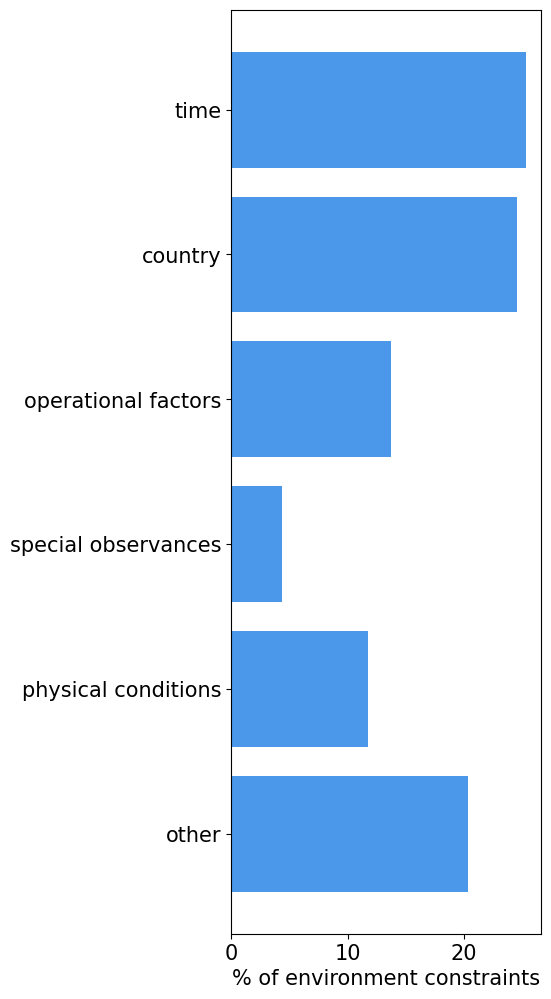

In [38]:
environment_subcategories = {
    'country': 'country',
    'attendance': 'operational factors',
    'cleanliness': 'operational factors',
    'noise': 'operational factors',
    'population density': 'operational factors',
    'privacy': 'operational factors',
    'lighting': 'physical conditions',
    'weather': 'physical conditions',
    'temperature': 'physical conditions',
    'holiday or special day': 'special observances',
    'day of the week': 'time',
    'season': 'time',
    'time of day': 'time',
    'time period': 'time'
}
COUNTER = Counter([environment_subcategories[x] \
                   if x in environment_subcategories\
                   #else x
                   else 'other'\
                   for x in stats_fine_df[stats_fine_df['category']=='the environment']['name'].values])

NAMES = dict([('time', 'time'),
         ('country', 'country'),
         ('operational factors', 'oper'),
         ('special observances', 'obsv'),
         ('physical conditions', 'phys'),
         ('other', 'other'),              
             ])
NAMESL = list(NAMES.keys())
COLORS = ['#4B98EB']*len(NAMESL)

tot = sum(COUNTER.values())
d = {NAMES[key]: (COUNTER[key]/tot) for key in NAMES}
plt.rcParams["figure.figsize"] = (4,12)
plt.rcParams['image.cmap'] = 'PuRd'
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots()

y_pos = np.arange(len(d.keys()))
x = [z*100 for z in d.values()]
ax.barh(y_pos, x, align='center', color=COLORS)
ax.set_yticks(y_pos)
ax.set_yticklabels(NAMESL)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of environment constraints')

plt.show()

In [39]:
d

{'time': 0.2535795840276492,
 'country': 0.24520150589397025,
 'oper': 0.13738196630253657,
 'obsv': 0.04334073936925261,
 'phys': 0.11755539097697958,
 'other': 0.2029408134296118}

### Overlap / Similarity Between Constraint Tables

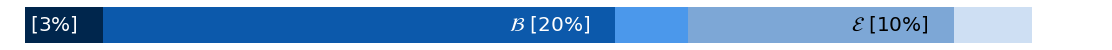

In [24]:
COLORS = ['#00264D', '#0C59AB', '#4B98EB', '#7DA7D6', '#CEDFF3', '#FFFFFF']
NAMES = {"the PERSON PERFORMING BEHAVIOR's attribute": r"$\mathcal{A}$",
         "the PERSON PERFORMING BEHAVIOR is also doing": r"$\mathcal{B}$",
         "the PERSON PERFORMING BEHAVIOR's role": r"$\mathcal{R}$",
         "the environment": r"$\mathcal{E}$",
         "some OTHER PERSON's attribute": r"$\mathcal{A}$",
         "some OTHER PERSON's role": r"$\mathcal{R}$"}
NAMESL = list(NAMES.values())

tot = stats_df['num_constraints'].sum()
d = {NAMES[category]: (stats_df[category].sum()/tot) for category in CJSON_EXP[0]}
ratios = [d[f] for f in NAMESL]
height = .2

plt.rcParams["figure.figsize"] = (15,0.5)
plt.rcParams['image.cmap'] = 'PuRd'


xpos = 0
y_pos = 0
ax = plt.gca()

for j in range(len(ratios)):
    width = ratios[j]
    plt.bar(xpos, height, width, bottom=0, color=COLORS[j], align='edge')
    xpos += width
    
    color = 'black' if j in {2,3,4,5} else 'white'
    text = f"{NAMESL[j]} [{ratios[j]*100:.0f}%]" if j in {0,1,3} else ''
    plt.text(xpos-0.01, 0.07, text, color=color,
             fontsize=20,
             ha='right'
            )

plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig('../img/categories.png', dpi=600, bbox_inches='tight')

In [13]:
## Fit all the constraint embeddings for later comparison
from utils import cosine_similarity
from sentence_transformers import SentenceTransformer
SBERT = SentenceTransformer('paraphrase-MiniLM-L6-v2')

all_constraints = list(all_constraints)
embeddings = SBERT.encode(all_constraints)
sim_M = cosine_similarity(np.array(embeddings), np.array(embeddings))

sims_dict = defaultdict(dict)
for i in range(len(all_constraints)):
    for j in range(len(all_constraints)):
        sims_dict[all_constraints[i]][all_constraints[j]] = sim_M[i, j]

In [22]:
c_beh = defaultdict(list)
c_setbeh = defaultdict(list)
for _, row in df.iterrows():
    try:
        CS = ConstraintSet(sims_dict)
        CS.from_mturk(row)
        c_beh[CS.behavior].append(CS)
        c_setbeh[(CS.setting,CS.behavior)].append(CS)
    except Exception as e:
        print(e)
        
similarities_dict = {}
row_idx = 0
for b in c_setbeh:
    constraints = c_setbeh[b]
    for i in range(len(constraints)):
        for j in range(i+1, len(constraints)):
            c_i = constraints[i]
            c_j = constraints[j]
            
            compare_dict = c_i.compare(c_j, sim_threshold=0.75)
            compare_dict['setting'] = b[0]
            compare_dict['behavior'] = b[1]
            compare_dict['sb'] = b
            compare_dict['count'] = len(constraints)
            similarities_dict[row_idx] = compare_dict
            row_idx += 1
            
similarities_df = pd.DataFrame.from_dict(similarities_dict).T

('Incompatible Constraints:', "[PERSON]'s role is 'renter'", "[PERSON]'s role is 'a renter'")
('Incompatible Constraints:', "[PERSON]'s role is 'driving instructor'", "[PERSON]'s role is 'driver'")
('Incompatible Constraints:', "[PERSON]'s age bracket is 'preschooler'", "[PERSON]'s age bracket is not 'preschooler'")
('Incompatible Constraints:', "[PERSON]'s role is 'passenger'", "[PERSON]'s role is 'driver'")
('Incompatible Constraints:', "[PERSON]'s role is 'athlete'", "[PERSON]'s role is not 'athlete'")
('Incompatible Constraints:', "[PERSON]'s role is 'officer'", "[PERSON]'s role is 'soldier'")
('Incompatible Constraints:', "[PERSON]'s role is 'volunteer'", "[PERSON]'s role is not 'volunteer'")
('Incompatible Constraints:', "time of day is 'early morning'", "time of day is 'night'")
('Incompatible Constraints:', "[PERSON]'s role is 'commentator'", "[PERSON]'s role is 'referee'")
('Incompatible Constraints:', "[PERSON]'s role is 'passenger'", "[PERSON]'s role is 'driver'")
('Incompat

In [25]:
import random 


def contribution_lengths_timeseries(constraint_sets, THRESH = 0.25):
    random.shuffle(constraint_sets)
    record_lengths = defaultdict(list)

    for level in {'expected', 'normal', 'taboo'}:
        TABLE_CLUSTERS = []
        for CS in constraint_sets:
            for table_s in CS.tables[level]:
                best_match = 0
                match_idx = -1
                for i in range(len(TABLE_CLUSTERS)):
                    for table_o in TABLE_CLUSTERS[i]:
                        sim = table_s.compare(table_o)['jaccard']
                        if sim > best_match:
                            best_match = sim
                            match_idx  = i
                if (best_match > THRESH) and (match_idx > -1):
                    TABLE_CLUSTERS[match_idx].add(table_s)
                else:
                    TABLE_CLUSTERS.append({table_s})

            record_lengths[level].append(len(TABLE_CLUSTERS))
    
    return record_lengths

/var/folders/r4/vf1g5l8x5xjbprn53mpq57xr0000gn/T/ipykernel_16745/3379461451.py:20: RuntimeWarning: Mean of empty slice
  RESULT[c][level] = np.nanmean(M, axis=0)
/var/folders/r4/vf1g5l8x5xjbprn53mpq57xr0000gn/T/ipykernel_16745/3379461451.py:18: RuntimeWarning: invalid value encountered in true_divide
  M = (M.T / np.nanmax(M, axis=1)).T


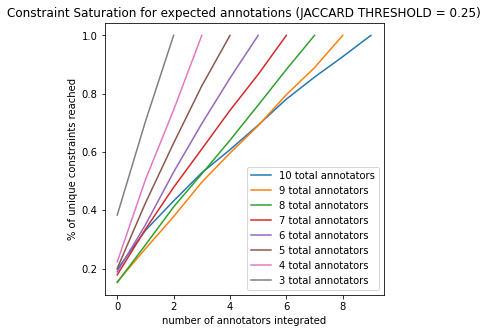

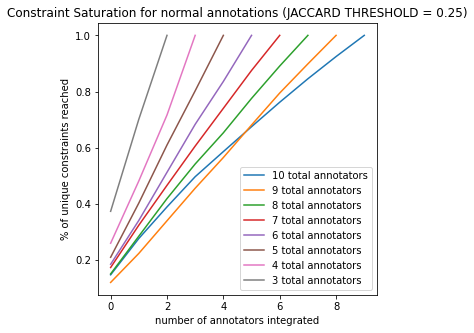

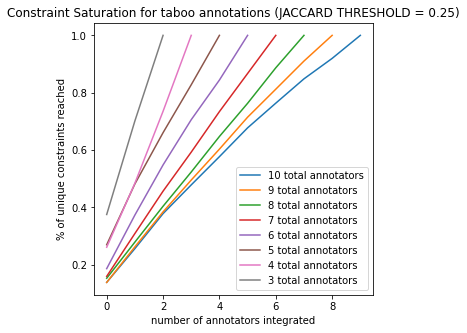

In [26]:
RESULT = defaultdict(lambda: defaultdict(list))
THRESH = 0.25

for c in range(1, 11):
    ALL = []
    for sb in set(similarities_df[similarities_df['count']==c]['sb']):
        constraint_sets = c_setbeh[sb]

        for j in range(30):
            record_lengths = dict(contribution_lengths_timeseries(constraint_sets, THRESH))
            ALL.append(record_lengths)

    for level in {'expected', 'normal', 'taboo'}:
        M = np.zeros((len(ALL), 10))
        M[:] = np.nan
        for i, record_lengths in enumerate(ALL):
            M[i, 0:len(record_lengths[level])] = np.array(record_lengths[level])
        M = (M.T / np.nanmax(M, axis=1)).T

        RESULT[c][level] = np.nanmean(M, axis=0)
        
for level in ['expected', 'normal', 'taboo']:
    plt.figure(figsize=(5,5))
    for i in range(10, 2, -1):
        plt.plot(RESULT[i][level], label=f"{i} total annotators")
        plt.legend()
        plt.xlabel('number of annotators integrated')
        plt.ylabel('% of unique constraints reached')
        plt.title(f"Constraint Saturation for {level} annotations (JACCARD THRESHOLD = {THRESH})")

/var/folders/r4/vf1g5l8x5xjbprn53mpq57xr0000gn/T/ipykernel_16745/1439184907.py:20: RuntimeWarning: Mean of empty slice
  RESULT[c][level] = np.nanmean(M, axis=0)
/var/folders/r4/vf1g5l8x5xjbprn53mpq57xr0000gn/T/ipykernel_16745/1439184907.py:18: RuntimeWarning: invalid value encountered in true_divide
  M = (M.T / np.nanmax(M, axis=1)).T


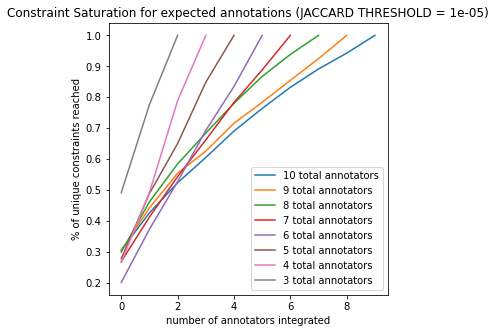

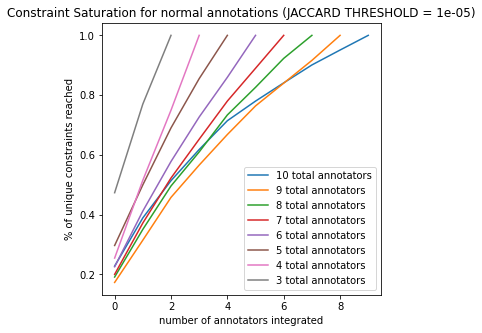

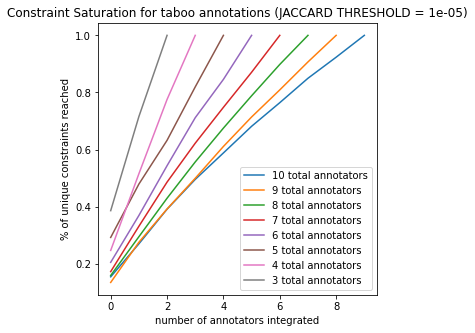

In [28]:
RESULT = defaultdict(lambda: defaultdict(list))
THRESH = 0.00001

for c in range(1, 11):
    ALL = []
    for sb in set(similarities_df[similarities_df['count']==c]['sb']):
        constraint_sets = c_setbeh[sb]

        for j in range(30):
            record_lengths = dict(contribution_lengths_timeseries(constraint_sets, THRESH))
            ALL.append(record_lengths)

    for level in {'expected', 'normal', 'taboo'}:
        M = np.zeros((len(ALL), 10))
        M[:] = np.nan
        for i, record_lengths in enumerate(ALL):
            M[i, 0:len(record_lengths[level])] = np.array(record_lengths[level])
        M = (M.T / np.nanmax(M, axis=1)).T

        RESULT[c][level] = np.nanmean(M, axis=0)
        
for level in ['expected', 'normal', 'taboo']:
    plt.figure(figsize=(5,5))
    for i in range(10, 2, -1):
        plt.plot(RESULT[i][level], label=f"{i} total annotators")
        plt.legend()
        plt.xlabel('number of annotators integrated')
        plt.ylabel('% of unique constraints reached')
        plt.title(f"Constraint Saturation for {level} annotations (JACCARD THRESHOLD = {THRESH})")

### Plot # annotations over time

In [23]:
from datetime import timedelta
from scipy.optimize import curve_fit

In [29]:
total = 0
num_settings = 0
b = set()
for fn in glob('../data/Behaviors-All-Hand-Filtered/*.txt'):
    with open(fn, 'r') as infile:
        l = infile.readlines()
        b.update(set(l))
        L = len(l)
        if L > 200:
            print(fn, L)
        total+=L
    num_settings += 1

../data/Behaviors-All-Hand-Filtered/restaurant.txt 227
../data/Behaviors-All-Hand-Filtered/gym.txt 240
../data/Behaviors-All-Hand-Filtered/athletic field.txt 385
../data/Behaviors-All-Hand-Filtered/army base.txt 257
../data/Behaviors-All-Hand-Filtered/backyard.txt 246
../data/Behaviors-All-Hand-Filtered/airplane cabin.txt 205
../data/Behaviors-All-Hand-Filtered/banquet hall.txt 210
../data/Behaviors-All-Hand-Filtered/church or chapel.txt 268


In [30]:
len(b)

7428

In [25]:
NUM_ANNOTATIONS_TARGET_UPPER = total*3
NUM_ANNOTATIONS_TARGET = total*2
NUM_ANNOTATIONS_TARGET_LOWER = num_settings*75*2

In [26]:
NUM_ANNOTATIONS_TARGET / NUM_ANNOTATIONS_TARGET_UPPER

0.6666666666666666

In [92]:
PERIODS = 30
X_ = []
X = []
Y = []
for upper_bound in pd.date_range(min(SPLITS_df['submit_time']), 
                                 (max(SPLITS_df['submit_time']) + timedelta(days=80)), 
                                 periods=PERIODS):
    
    if upper_bound <= max(SPLITS_df['submit_time']):
        consider = SPLITS_df[SPLITS_df['submit_time']<=upper_bound].copy()
        grouping = consider.groupby(['setting', 'behavior', 'worker_id']).count()
        grouping['dummy'] = 1
        annotations_per_setting_behavior = grouping.groupby(['setting', 'behavior']).count()['dummy']
        capped_apsb = annotations_per_setting_behavior.apply(lambda x: 2 if x>2 else x)

        X.append(upper_bound)
        Y.append(capped_apsb.sum())
    X_.append(upper_bound)

In [93]:
x = np.array(list(range(0,len(X))))
fit = curve_fit(lambda t,a,b: a*np.exp(b*t),
                  x,
                  Y
         )

a,b = fit[0]

def f(t, a, b):
    return a*np.exp(b*t)
 
FIT_X = np.array(list(range(0,len(X_))))
FIT_Y = np.array([f(t, a, b) for t in range(0,len(FIT_X))] )

In [94]:
FIT_X

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

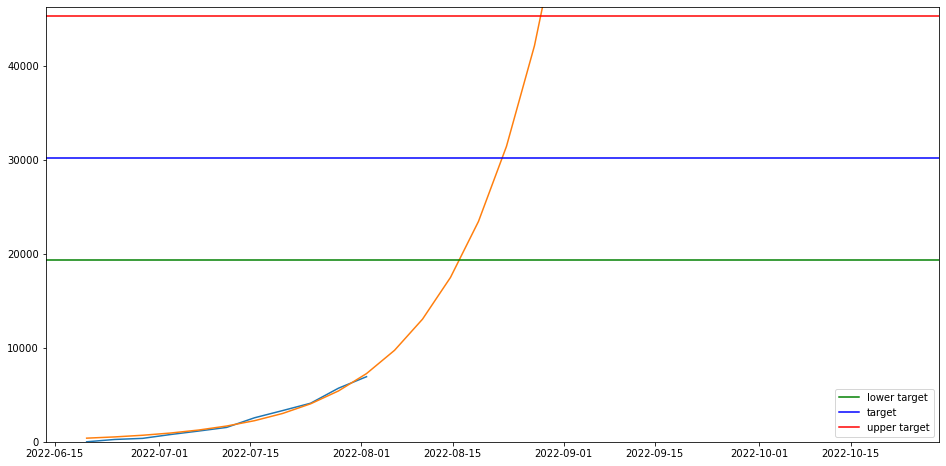

In [110]:
plt.figure(figsize=(16,8))
plt.plot(X,Y)
plt.plot(X_,FIT_Y)
plt.ylim(0, NUM_ANNOTATIONS_TARGET_UPPER+1000)
plt.axhline(NUM_ANNOTATIONS_TARGET_LOWER, color='green', label='lower target')
plt.axhline(NUM_ANNOTATIONS_TARGET, color='blue', label='target')
plt.axhline(NUM_ANNOTATIONS_TARGET_UPPER, color='red', label='upper target')
plt.legend()
plt.show()

In [44]:
X

Timestamp('2022-08-03 07:27:57-0700', tz='pytz.FixedOffset(-420)')

In [33]:
gr

42

### Example Constraints

In [14]:
list(SPLITS_df.columns)

["the PERSON PERFORMING BEHAVIOR's attribute",
 'the PERSON PERFORMING BEHAVIOR is also doing',
 'setting',
 'behavior',
 'setting-behavior',
 'norm',
 'worker_id',
 'constraints',
 'string_length',
 'num_constraints',
 'label',
 'preset_category',
 'preset_name',
 'preset_relation',
 'preset_value',
 'dummy',
 "some OTHER PERSON's attribute",
 'the environment',
 "the PERSON PERFORMING BEHAVIOR's role",
 "some OTHER PERSON's role",
 'split']

In [18]:
all_constraint_sets[0].tables['expected'][0].constraints

In [27]:
c=0
for i, r in SPLITS_df.iterrows():
    print(f"{i}\t\t{r['setting']}\t\t{r['behavior']}")
    c+=1
    if c > 100:
        break

6693		balcony		sit alone
8831		banquet hall		put tobacco products on the table
31739		campsite		chop down a tree for firewood
27931		army base		go to a party
24957		armchair		watch a horror movie
37176		cornfield		roll around
12105		bus		wear a cross
17824		bar		touch someone's belongings
34817		boxing hall		harm or injure another person
6467		cafe		ask for a croissant
34516		armchair		lean back
26614		courthouse		interview the witnesses
9172		basement		sleep on the floor
14488		auditorium		check for valid tickets
37134		bookstore		browse the books
31582		athletic field		chew tobacco
27889		dentists office		wear headphones
27636		athletic field		wear a bathing suit
6155		amusement park		wear high heels
7926		airplane		watch a movie
22276		backyard		put up a bird feeder
7652		attic		wear a hijab
4647		basement		change your clothes
38685		bus		honk the horn
10597		bank		work
29669		cemetery		sweep the sidewalks
31188		elevator		do a handstand
9436		arena		wear a sari
13713		athletic fiel

In [32]:
SPLITS_df.loc[7853]['constraints']

"[OTHER]'s role is 'spectator' [AND] [PERSON]'s behavior is 'dance with your significant other' [AND] [PERSON]'s behavior is 'engage in public displays of affection' [AND] [PERSON]'s behavior is 'go on a date' [AND] [PERSON]'s behavior is 'hold hands with someone' [AND] [PERSON]'s behavior is 'hug someone' [AND] [PERSON]'s behavior is 'lose focus during the game'"

In [33]:
SPLITS_df.loc[6421]['constraints']

"[PERSON]'s age bracket is not 'middle-aged adult' [AND] [PERSON]'s age bracket is not 'older adult' [AND] [PERSON]'s age bracket is not 'senior citizen' [AND] [PERSON]'s age bracket is not 'young adult'"

In [20]:
SPLITS_df['behavior'].i

6693                                sit alone
8831        put tobacco products on the table
31739           chop down a tree for firewood
27931                           go to a party
24957                    watch a horror movie
                         ...                 
25698                take your wedding photos
9018                                cut paper
37946                         dance in public
26296                              wear a hat
3550     bring a sick animal into the shelter
Name: behavior, Length: 38821, dtype: object

### Pulling for MTurk Eval

In [8]:
expectation = {
    'taboo': 'unexpected',
    'normal': 'okay',
    'expected': 'expected'
}

out_data = {}
idx = 0
for CS in all_constraint_sets:
    for table_name in CS.tables:
        for table in CS.tables[table_name]:
            stat = {}
            stat['setting'] = CS.setting
            stat['behavior'] = CS.behavior
            stat['expectation'] = expectation[table_name]
            stat['constraints_html'] = table.html_representation()
            
            for i, c in enumerate(table.constraints): 
                stat[f"category_{i+1}"] = c.category
                stat[f"name_{i+1}"] = c.name
                stat[f"relation_{i+1}"] = c.relation
                stat[f"value_{i+1}"] = c.value
                stat[f"constraint_{i+1}"] = c.human_str()
                for level in ['category', 'name', 'relation', 'value']:
                    stat[f"is_preset_{level}_{i+1}"] = c.is_preset(level)

            stat['num_constraints'] = len(table)
            out_data[idx] = stat
            idx+=1
            
out_df = pd.DataFrame.from_dict(out_data).T

In [11]:
sample = out_df.sample(n=300, random_state=4).copy()

In [12]:
list(sample.columns)

['setting',
 'behavior',
 'expectation',
 'constraints_html',
 'category_1',
 'name_1',
 'relation_1',
 'value_1',
 'constraint_1',
 'is_preset_category_1',
 'is_preset_name_1',
 'is_preset_relation_1',
 'is_preset_value_1',
 'num_constraints',
 'category_2',
 'name_2',
 'relation_2',
 'value_2',
 'constraint_2',
 'is_preset_category_2',
 'is_preset_name_2',
 'is_preset_relation_2',
 'is_preset_value_2',
 'category_3',
 'name_3',
 'relation_3',
 'value_3',
 'constraint_3',
 'is_preset_category_3',
 'is_preset_name_3',
 'is_preset_relation_3',
 'is_preset_value_3',
 'category_4',
 'name_4',
 'relation_4',
 'value_4',
 'constraint_4',
 'is_preset_category_4',
 'is_preset_name_4',
 'is_preset_relation_4',
 'is_preset_value_4',
 'category_5',
 'name_5',
 'relation_5',
 'value_5',
 'constraint_5',
 'is_preset_category_5',
 'is_preset_name_5',
 'is_preset_relation_5',
 'is_preset_value_5',
 'category_6',
 'name_6',
 'relation_6',
 'value_6',
 'constraint_6',
 'is_preset_category_6',
 'is_pre

In [13]:
sample.to_csv('../hit/peer_review/input/end_of_internship_eval.csv', index=False)

## misc.

In [8]:
d = defaultdict(set)
a = set()
r = defaultdict(set)
for _, row in df.sample(frac=1, random_state=0).iterrows():
    CS = ConstraintSet({})
    try:
        CS.from_mturk(row)
        all_constraint_sets.append(CS)
        for table_name in CS.tables:
            for CT in CS.tables[table_name]:
                for c in CT.constraints:
                    if c.category=='the environment' and not c.is_preset(level='name'):
                        d[c.name].add(c.value)
                        a.add(c.value)
                        r[c.value].add(c.name)
    except Exception as e:
        pass
        #print(e)

matched [OTHER]'s medical condition is 'sick' to [OTHER]'s condition or state is 'sick'
matched [PERSON]'s condition or state is 'short' to [PERSON]'s characteristic is 'short'
matched [OTHER]'s education is 'algeria' to [OTHER]'s country is 'algeria'
matched [OTHER]'s busyness is 'busy' to [OTHER]'s condition or state is 'busy'
matched [PERSON]'s hotel lobby role is not 'preschooler' to [PERSON]'s age bracket is not 'preschooler'
matched [PERSON]'s characteristic is 'drunk' to [PERSON]'s condition or state is 'drunk'
matched [PERSON]'s characteristic is not 'vegan' to [PERSON]'s diet is not 'vegan'
matched [PERSON]'s characteristic is 'vegan' to [PERSON]'s diet is 'vegan'
matched [OTHER]'s condition or state is 'dangerous' to [OTHER]'s characteristic is 'dangerous'
matched [PERSON]'s condition or state is 'dangerous' to [PERSON]'s characteristic is 'dangerous'
matched noise from snore is not 'quiet' to noise is not 'quiet'
matched temperature of food is 'hot' to temperature is 'hot'
m

matched [PERSON]'s money is 'wealthy' to [PERSON]'s social class is 'wealthy'
matched [PERSON]'s money is 'wealthy' to [PERSON]'s social class is 'wealthy'
matched holiday is 'feast of the epiphany' to holiday or special day is 'feast of the epiphany'
matched [OTHER]'s (other) adjective is 'criminal' to [OTHER]'s characteristic is 'criminal'
matched [OTHER]'s (other) adjective is not 'violent' to [OTHER]'s characteristic is not 'violent'
matched [PERSON]'s (other) adjective is not 'violent' to [PERSON]'s characteristic is not 'violent'
matched [PERSON]'s condition or state is 'employed' to [PERSON]'s employment is 'employed'
matched shoe condition is 'clean' to cleanliness is 'clean'
matched shoe condition is 'dirty' to cleanliness is 'dirty'
matched [PERSON]'s medical condition is 'deaf' to [PERSON]'s characteristic is 'deaf'
matched [PERSON]'s hand state is not 'dirty' to [PERSON]'s condition or state is not 'dirty'
matched [PERSON]'s hand state is 'clean' to [PERSON]'s condition or 

matched [PERSON]'s characteristic is 'poor' to [PERSON]'s social class is 'poor'
matched [PERSON]'s condition or state is 'disabled' to [PERSON]'s employment is 'disabled'
matched noise in room is 'quiet' to noise is 'quiet'
matched [PERSON]'s characteristic is 'weak' to [PERSON]'s condition or state is 'weak'
matched [PERSON]'s disability is not 'epilepsy' to [PERSON]'s medical condition is not 'epilepsy'
matched [PERSON]'s disability is not 'epilepsy' to [PERSON]'s medical condition is not 'epilepsy'
matched [PERSON]'s disability is 'epilepsy' to [PERSON]'s medical condition is 'epilepsy'
matched [PERSON]'s (other) adjective is not 'barren' to [PERSON]'s characteristic is not 'barren'
matched [OTHER]'s (other) adjective is 'clean' to [OTHER]'s condition or state is 'clean'
matched [PERSON]'s (other) adjective is not 'drunk' to [PERSON]'s condition or state is not 'drunk'
matched [PERSON]'s happiness level is 'high' to [PERSON]'s condition or state is 'high'
matched audio setting is '

In [ ]:
aliases = {
    'holiday': 'holiday or special day',
    'holiday or special day/event': 'holiday or special day',
    'holiday or special day/special event': 'holiday or special day',
    
}

In [16]:
print('\n'.join(sorted(d.keys())))

abode type
access
access restriction
access/permissions
accident scene status
accommodations
activity
activity in current lane
activity on field
age of boat
age restriction
air
air quality
airplane location
airplane movement status
airplane status
airplane toilet
airplane turbulence
airplane turbulence level
airplane turbulence status
airplanes location
alarm
allowed/permission
allowed/permitted
also
alter location
amount of food
amusement park enviroment
amusement park ride
animal shelter is small in size and overpopulated
animal type
animals present
apartment floor
apartment rules
appliance status
appointment location
appropriateness
arcade
arcade rules
area
area cleaned
area free of dangerous junk
area of canyon
area status
arena
arena event
arena place
army base rules
around
arrival pending
arrmy base
art gallery rules
artwork location
athletic field
athletic field event
athletic field sport
attendance
attic
attic access
attic ceiling
attic condition
attic environment
attic furnitu

In [134]:
print('\n'.join(sorted(d['road conditions'])))

hazardous


In [27]:
print('\n'.join(sorted(a)))

0
1
15 minutes
18+
2
2020
2021
5 to 10 minutes away
6 feet
a beach cleaner injured their foot on broken glass at the beach
a business presentation for clients
a film set
a formal gathering
a horror movie being filmed at the cemetery
a landscaper.
a mobile game in delevopment
a no burn order/burn ban
a river
a rodent or pest
a sporting event is happening
abandoned
abandoned building
about spouses arguing
above maximum permitted
acceptable
accepting of lgbtq people
accessible
accident caused by apron getting caught on something
accident in current lane
accident or sudden danger
accidentally dropping something
active church
active shooter in building
active war zone
adecuate for a barbecue
adequate
adoption finalized
adult club
adult movie set
adults only
advertisement
affiliated
after the movie ends
against rules
age 10 and younger
aggressive dog
air
air force one or private business plane
airplane cabin
airplane is actively crashing
airplane mode
ala
alabama, arkansas, idaho, oklahoma, 

In [9]:
r['dizzy']

set()

In [136]:
d['weather condition']

{'hazardous'}

In [13]:
r = defaultdict(set)

VALUE_TO_NAME = defaultdict(lambda: defaultdict(set))
for code, key in zip(['E', 'A'],
                     ['the environment', "the PERSON PERFORMING BEHAVIOR's attribute"]):
    for k in list(CONSTRAINT_JSON[key].keys()):
        for kk in list(CONSTRAINT_JSON[key][k]):
            name = sanitize(k)
            value = sanitize(kk)

            VALUE_TO_NAME[code][value].add(name)
            
            r[name].add((code, value))

In [12]:
VALUE_TO_NAME['A']

defaultdict(set,
            {'infant': {'age bracket'},
             'toddler': {'age bracket'},
             'preschooler': {'age bracket'},
             'gradeschooler': {'age bracket'},
             'teen': {'age bracket'},
             'young adult': {'age bracket'},
             'middle-aged adult': {'age bracket'},
             'older adult': {'age bracket'},
             'senior citizen': {'age bracket'},
             'barren': {'characteristic'},
             'blonde': {'characteristic'},
             'buff': {'characteristic'},
             'bald': {'characteristic'},
             'chubby': {'characteristic'},
             'criminal': {'characteristic'},
             'disobedient': {'characteristic'},
             'dangerous': {'characteristic'},
             'devout': {'characteristic'},
             'deaf': {'characteristic'},
             'expert': {'characteristic'},
             'extroverted': {'characteristic'},
             'educated': {'characteristic'},
             

In [14]:
VALUE_TO_NAME['A']['dizzy']

set()

In [16]:
CONSTRAINT_JSON["the PERSON PERFORMING BEHAVIOR's attribute"].keys()

dict_keys(['age bracket', 'characteristic', 'children', 'condition or state', 'country', 'diet', 'education', 'employment', 'gender', 'marriage', 'medical condition', 'race or ethnicity', 'religion', 'sexuality', 'social class'])

In [17]:
CONSTRAINT_JSON["the PERSON PERFORMING BEHAVIOR's attribute"]['medical condition']

['autistic spectrum disorder (asd)',
 "alzheimer's disease",
 'arthritis',
 'anorexia',
 'ADHD',
 'abdominal pain',
 'asbestosis',
 'acne',
 'anxiety',
 'airsickness',
 'aneurysm',
 'anal cancer',
 'ankylosing spondylitis',
 'appendicitis',
 'anaphylaxis',
 'angioedema',
 'allergies',
 'asthma',
 "addison's disease",
 'benign prostate enlargement',
 'bronchitis',
 'bowel incontinence',
 'bile duct cancer',
 'bowel cancer',
 'bipolar disorder',
 'bone cancer',
 'brain injury',
 'back pain',
 'binge eating',
 'brain cancer',
 'bunion',
 'bulimia',
 'bowel polyps',
 'breast cancer',
 'bronchiectasis',
 'bacterial vaginosis',
 'brain stem death',
 'bladder cancer',
 'blood poisoning',
 'cellulitis',
 'chilblains',
 'constipation',
 'congenital heart disease',
 'clostridium difficile',
 'chronic pain',
 'cystic fibrosis',
 'croup',
 "crohn's disease",
 'cold sore',
 'cirrhosis',
 'chest pain',
 'conjunctivitis',
 'coronavirus',
 'cholecystitis',
 'catarrh',
 'coma',
 'common cold',
 'cervic

In [6]:
dd = pd.read_csv('SCENE.csv')

In [7]:
dd

,setting,behavior,setting-behavior,constraints,constraints_given,constraint_predict,norm,label,split
0,bar,hang out with a group of only one gender,bar [BEHAVIOR] hang out with a group of only o...,[PERSON]'s behavior is 'looking for a hook up'...,type of bar is 'gay bar' [AND],[PERSON]'s behavior is 'looking for a hook up',expected,2,train
1,childs room,kill a bug on the floor,childs room [BEHAVIOR] kill a bug on the floor,[PERSON]'s behavior is 'get rid of insect that...,[AND],[PERSON]'s behavior is 'get rid of insect that...,normal,1,train
2,courthouse,advocate for the overthrow of the government,courthouse [BEHAVIOR] advocate for the overthr...,[PERSON]'s role is 'judge' [AND] court case is...,[PERSON]'s role is 'judge' [AND],court case is not 'government related',taboo,0,test
3,army base,leave food out,army base [BEHAVIOR] leave food out,[PERSON]'s characteristic is not 'lazy' [AND] ...,[PERSON]'s characteristic is not 'lazy' [AND] ...,[PERSON]'s behavior is 'respond to emergency',expected,2,train
4,country road,run a stop sign,country road [BEHAVIOR] run a stop sign,[OTHER]'s role is 'passenger' [AND] [OTHER]'s ...,[OTHER]'s medical condition is 'stroke' [AND] ...,[PERSON]'s condition or state is 'alert',normal,1,dev
...,...,...,...,...,...,...,...,...,...
38345,backyard,name the planets,backyard [BEHAVIOR] name the planets,[PERSON]'s age bracket is 'toddler',[AND],[PERSON]'s age bracket is 'toddler',taboo,0,train
38346,attic,sanitize the area,attic [BEHAVIOR] sanitize the area,cleanliness is 'clean',[AND],cleanliness is 'clean',taboo,0,dev
38347,dance studio,participate in class,dance studio [BEHAVIOR] participate in class,[PERSON]'s role is 'student' [AND] [PERSON]'s ...,[PERSON]'s medical condition is 'leg cramps' [...,[PERSON]'s role is 'student',taboo,0,train
38348,athletic field,spell your name out loud,athletic field [BEHAVIOR] spell your name out ...,[PERSON]'s behavior is 'playing/competing' [AN...,[PERSON]'s behavior is 'reporting' [AND] reaso...,[PERSON]'s behavior is 'playing/competing',normal,1,train


In [48]:
e

{'attendance': ['crowded', 'empty', 'there are people around'],
 'cleanliness': ['clean', 'dirty'],
 'day of the week': ['Sunday',
  'Monday',
  'Tuesday',
  'Wednesday',
  'Thursday',
  'Friday',
  'Saturday'],
 'event type': ['adults only',
  'formal',
  'group discussion',
  'informal',
  'men only',
  'no event',
  'religious',
  'women only'],
 'holiday or special day': ['420',
  '9-11 Remembrance',
  "Ascension of Baháʼu'lláh",
  "All Saints' Day",
  "April Fools' Day",
  'All Souls Day',
  'Anniversary',
  'Advent',
  'Arbor Day',
  'Ash Wednesday',
  'Australia Day',
  'Autumnal Equinox',
  'Boxing Day',
  'Bar Mitzvah',
  'Baby Shower',
  "Birth of Baháʼu'lláh",
  'Birthday',
  'Birth of the Báb',
  'Black Friday',
  'Bat Mitzvah',
  'Christmas',
  'Cyber Monday',
  'Columbus Day',
  'Canada Day',
  'Confirmation',
  'Cinco de Mayo',
  'Dia de los Muertos',
  'Dormition of the Theotokos',
  'Eid al-Fitr',
  'Election Day',
  'Eid al-Adha',
  'Easter',
  'Earth Day',
  'Feast o

In [47]:
CONSTRAINT_JSON

{'the environment': {'attendance': ['crowded',
   'empty',
   'there are people around'],
  'cleanliness': ['clean', 'dirty'],
  'day of the week': ['Sunday',
   'Monday',
   'Tuesday',
   'Wednesday',
   'Thursday',
   'Friday',
   'Saturday'],
  'event type': ['adults only',
   'formal',
   'group discussion',
   'informal',
   'men only',
   'no event',
   'religious',
   'women only'],
  'holiday or special day': ['420',
   '9-11 Remembrance',
   "Ascension of Baháʼu'lláh",
   "All Saints' Day",
   "April Fools' Day",
   'All Souls Day',
   'Anniversary',
   'Advent',
   'Arbor Day',
   'Ash Wednesday',
   'Australia Day',
   'Autumnal Equinox',
   'Boxing Day',
   'Bar Mitzvah',
   'Baby Shower',
   "Birth of Baháʼu'lláh",
   'Birthday',
   'Birth of the Báb',
   'Black Friday',
   'Bat Mitzvah',
   'Christmas',
   'Cyber Monday',
   'Columbus Day',
   'Canada Day',
   'Confirmation',
   'Cinco de Mayo',
   'Dia de los Muertos',
   'Dormition of the Theotokos',
   'Eid al-Fitr',
 

In [33]:
settings = []
for fn in sorted(glob('../data/Settings-Roles/*.txt')):
    s = fn.split('/')[-1][:-4]
    if s != 'airplane cabin':
        settings.append(f"(\\texttt{{{i}}}) {s}")
        
        with open(fn, 'r') as infile:
            roles = sorted(set([x.strip() for x in infile.readlines()]))
            roles = [f"(\\texttt{{{j+1}}}) {r}" for j, r in enumerate(roles)]
            if len(roles):
                print(f"\item \\textbf{{{s}}}: {', '.join(roles)}")
            else:
                print(f"\item \\textbf{{{s}}}: NO ROLES")

\item \textbf{airplane}: (\texttt{1}) air traffic controller, (\texttt{2}) co-pilot, (\texttt{3}) flight attendant, (\texttt{4}) flight engineer, (\texttt{5}) navigator, (\texttt{6}) pilot
\item \textbf{airport terminal}: (\texttt{1}) air traffic controller, (\texttt{2}) airport security, (\texttt{3}) baggage handler, (\texttt{4}) food and beverage vendor, (\texttt{5}) groundskeeper, (\texttt{6}) ticketing agent
\item \textbf{airport}: (\texttt{1}) air traffic controller, (\texttt{2}) airplane co-pilot, (\texttt{3}) airplane pilot, (\texttt{4}) baggage handler, (\texttt{5}) ground crew, (\texttt{6}) ticket agent
\item \textbf{alcoholics ward}: (\texttt{1}) alcoholism counselor, (\texttt{2}) doctor, (\texttt{3}) nurse, (\texttt{4}) patient, (\texttt{5}) psychiatrist, (\texttt{6}) psychologist, (\texttt{7}) social worker
\item \textbf{altar}: (\texttt{1}) assistant, (\texttt{2}) greeter, (\texttt{3}) leader, (\texttt{4}) reader, (\texttt{5}) server, (\texttt{6}) singer
\item \textbf{amus

In [28]:
roles

['animal trainer', 'curator', 'veterinarian', 'zookeeper']

In [57]:
d_setting = defaultdict(set)
d_role = defaultdict(set)

for fn in sorted(glob('../data/Settings-Items/*.txt')):
    s = fn.split('/')[-1][:-4]
    if s != 'airplane cabin':
        
        with open(fn, 'r') as infile:
            d_setting[s].update(set([x.strip() for x in infile.readlines()]))
            
for fn in sorted(glob('../data/Settings-Roles-Items/*/*.txt')):
    sr = fn.split('/')[-1][:-4]
    s = sr.split('_')[0]
    with open(fn, 'r') as infile:
        items = set([x.strip() for x in infile.readlines()])
        d_role[sr].update(items)
        d_setting[s].update(items)

In [58]:
np.array([len(d_role[key]) for key in d_role]).mean()

7.969086987778576

In [59]:
np.array([len(d_setting[key]) for key in d_setting]).mean()

42.12167300380228

In [60]:
d_behav = defaultdict(set)

for fn in sorted(glob('../data/Behaviors-All-Merged/*.txt')):
    s = fn.split('/')[-1][:-4]
    if s != 'airplane cabin':
        
        with open(fn, 'r') as infile:
            d_behav[s].update(set([x.strip() for x in infile.readlines()]))

In [62]:
np.array([len(d_behav[key]) for key in d_behav]).mean()

539.9150579150579

In [66]:
d_behav = defaultdict(set)

for fn in sorted(glob('../data/Behaviors-All-Hand-Filtered/*.txt')):
    s = fn.split('/')[-1][:-4]
    if s != 'airplane cabin':
        
        with open(fn, 'r') as infile:
            d_behav[s].update(set([x.strip() for x in infile.readlines()]))

In [67]:
np.array([len(d_behav[key]) for key in d_behav]).mean()

112.625

In [63]:
behaviors_dict = defaultdict(set)
fns = sorted(glob('../data/Settings-Roles-Behaviors_Taboo/*/*.txt'))
fns += sorted(glob('../data/Settings-Roles-Behaviors_Normal/*/*.txt'))
fns += sorted(glob('../data/Settings-Attributes-Behaviors_Taboo/*/*.txt'))
for fn in tqdm(fns):
    name = fn.split('/')[-1][:-4]
    setting, role = name.split('_')
    with open(fn, 'r') as infile:
        
        add = set([x for x in infile.readlines()])
        behaviors_dict[setting].update(add)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 57440/57440 [01:39<00:00, 577.24it/s]


In [65]:
np.array([len(behaviors_dict[key]) for key in behaviors_dict]).mean()

776.4904214559386

In [68]:
CONSTRAINT_JSON['the PERSON PERFORMING BEHAVIOR is also doing']['dentists office behavior']

['ask for a toothbrush',
 'avoid moving your head or neck too much',
 'act seductively',
 'answer phone calls',
 'ask for a mouthguard',
 'answer patient questions',
 'bring a bottle of champagne',
 'bring a box of chocolates',
 'bring food',
 'brush your teeth',
 'bite someone',
 'bring a bouquet of flowers',
 'bring a pet',
 'blow your nose',
 'bring a weapon',
 "brush someone's teeth",
 'cry',
 'curse',
 'chew gum',
 'curl up in a ball',
 'cleaning teeth',
 'caugh',
 'drink water',
 'do a crossword puzzle',
 'diagnose dental conditions',
 'drink soda',
 'dance',
 'drink alcohol',
 "drill a hole in someone's tooth",
 'drink milk',
 'eat food',
 'exercise',
 'flirt with someone',
 'give someone your phone number',
 'get braces',
 'get a filling',
 'get dentures',
 'get drunk',
 'get angry',
 'gargle',
 'go',
 'get a cleaning',
 'get up and walk around',
 'get a tooth pulled',
 "hold someone's hand",
 'hum a tune',
 'jump up and down',
 "judge someone's teeth",
 'kiss someone',
 'lick 

In [69]:
staging = pd.concat([pd.read_csv(fn, low_memory=False) for fn in glob('../hit/output/Stage*.csv')])

In [70]:
len(staging)

2502

In [15]:
stats_df[(stats_df['setting']=='dentists office') & (stats_df['behavior']=='open your mouth wide')]

,the environment,the PERSON PERFORMING BEHAVIOR's role,setting,behavior,setting-behavior,norm,worker_id,submit_time,preset_category,preset_name,...,some OTHER PEOPLE's attribute,object of behavior properties,SOME OTHER PERSON is also doing,the plant,some OTHER PERSON's was doing,the PERSON PERFORMING BEHAVIOR behavior properties,activity property,the PERSON PERFORMING BEHAVIOR'sparaplegi attribute,Equipment status,item propeties
14046,1,1,dentists office,open your mouth wide,dentists office [BEHAVIOR] open your mouth wide,expected,A249LDVPG27XCE,2022-07-29 23:31:25-07:00,7,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14047,1,1,dentists office,open your mouth wide,dentists office [BEHAVIOR] open your mouth wide,normal,A249LDVPG27XCE,2022-07-29 23:31:25-07:00,8,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14048,NaN,1,dentists office,open your mouth wide,dentists office [BEHAVIOR] open your mouth wide,taboo,A249LDVPG27XCE,2022-07-29 23:31:25-07:00,8,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39954,NaN,NaN,dentists office,open your mouth wide,dentists office [BEHAVIOR] open your mouth wide,expected,A39SK1E6IMQBD5,2022-07-28 04:17:08-07:00,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39955,NaN,NaN,dentists office,open your mouth wide,dentists office [BEHAVIOR] open your mouth wide,normal,A39SK1E6IMQBD5,2022-07-28 04:17:08-07:00,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39956,NaN,NaN,dentists office,open your mouth wide,dentists office [BEHAVIOR] open your mouth wide,taboo,A39SK1E6IMQBD5,2022-07-28 04:17:08-07:00,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
import pandas as pd
import json, re, argparse, os
from glob import glob

def person_split(txt):
    return [x for x in re.split(r"(?=(PERSON|OTHER))",txt) if len(x) and x not in {'PERSON', 'OTHER'}]

def person_subdivide(lst):
    new_lst = []
    for x in lst:
        for y in person_split(x):
            new_lst.append(y)
    return new_lst

def clean_constraints(txt):
    
    txt = re.sub("[\s]+’s", "'s", txt)
    txt = re.sub("[\s]+'s", "'s", txt)
    txt = re.sub("[\s]{2,}", " ", txt)
    txt = re.sub("’", "'", txt)
    txt = re.sub('<[\w//]+>', '', txt)
    txt = re.sub(':', '', txt)
    txt = re.sub('\[PERSON\]', 'PERSON', txt)
    txt = re.sub('\[OTHER\]', 'OTHER', txt)
    txt = re.sub('PERSON.s', "PERSON's", txt)
    txt = re.sub("PERSON(' | ')(s|S)\b", "PERSON's", txt)
    txt = re.sub(r"has not '", "is not '", txt)
    
    constraints = person_subdivide(txt.split('[AND]'))
    
    def clean_constraint(txt):
        txt = re.sub('[\.//]', '', txt)
        return txt.strip()
    
    cleaned = [clean_constraint(c) for c in constraints]
    
    out = [c for c in cleaned if len(c)]
    if len(out):
        return out
    return ['']

scene = pd.read_csv('SCENE.csv')
gen = pd.read_csv('../hit/peer_review_gen/input/gen_hit.csv')
s = set([f"{row['setting']}-{row['behavior']}" for _, row in gen.iterrows()])

out_data = {}
idx = 0
for _, row in scene.iterrows():
    
    if f"{row['setting']}-{row['behavior']}" in s:

        out_idx = {}
        constraints = clean_constraints(row['constraints'])
        inner_html = ' '.join([f"<li>{constraint}</li>" for constraint in constraints])
        out_idx['constraints_html'] = f"""<ol>{inner_html}</ol>"""
        for i, constraint in enumerate(constraints):
            out_idx[f'constraint_{i+1}'] = constraint

        out_idx['num_constraints'] = len(constraints)
        out_idx['setting'] = row['setting']
        out_idx['behavior'] = row['behavior']
        out_idx['expectation'] = row['norm']

        out_data[idx] = out_idx
        idx+=1
out_df = pd.DataFrame.from_dict(out_data).T
out_df.to_csv('../hit/peer_review/input/end_of_internship_eval.csv', index=False)

In [32]:
scene = pd.read_csv('SCENE.csv')

In [60]:
scene[(scene['behavior']=='drink coffee') ]#& (scene['setting']=='grocery store') & (scene['norm']=='okay')

,setting,behavior,setting-behavior,constraints,constraints_given,constraint_predict,norm,label,split
577,classroom,drink coffee,classroom [BEHAVIOR] drink coffee,[PERSON]'s role is 'school counselor' [AND] [P...,[PERSON]'s condition or state is 'tired' [AND]...,[PERSON]'s condition or state is 'working',normal,1,dev
905,cinema,drink coffee,cinema [BEHAVIOR] drink coffee,[PERSON]'s age bracket is not 'gradeschooler' ...,[PERSON]'s age bracket is not 'infant' [AND] [...,[PERSON]'s age bracket is not 'gradeschooler',normal,1,train
1502,hospital,drink coffee,hospital [BEHAVIOR] drink coffee,[PERSON]'s role is 'cleaner',[AND],[PERSON]'s role is 'cleaner',normal,1,test
2492,athletic field,drink coffee,athletic field [BEHAVIOR] drink coffee,[PERSON]'s role is 'athlete',[AND],[PERSON]'s role is 'athlete',taboo,0,test
3463,athletic field,drink coffee,athletic field [BEHAVIOR] drink coffee,[PERSON]'s role is 'athlete' [AND] [PERSON]'s ...,[PERSON]'s behavior is 'play football' [AND],[PERSON]'s role is 'athlete',taboo,0,test
4108,athletic field,drink coffee,athletic field [BEHAVIOR] drink coffee,[PERSON]'s role is 'sport sociologist' [AND] [...,[PERSON]'s role is 'sport sociologist' [AND],[PERSON]'s behavior is 'analyze the impact of ...,normal,1,test
7013,hospital,drink coffee,hospital [BEHAVIOR] drink coffee,[PERSON]'s role is 'server',[AND],[PERSON]'s role is 'server',normal,1,test
8567,classroom,drink coffee,classroom [BEHAVIOR] drink coffee,[PERSON]'s role is 'student' [AND] [PERSON]'s ...,[PERSON]'s role is 'student' [AND] [PERSON]'s ...,[PERSON]'s condition or state is 'energetic',taboo,0,dev
8939,cinema,drink coffee,cinema [BEHAVIOR] drink coffee,[PERSON]'s age bracket is 'preschooler',[AND],[PERSON]'s age bracket is 'preschooler',taboo,0,train
9080,athletic field,drink coffee,athletic field [BEHAVIOR] drink coffee,[PERSON]'s role is 'coach' [AND] time of day i...,[PERSON]'s role is 'coach' [AND],time of day is 'early morning',normal,1,test


In [48]:
set(scene['behavior'].values)

{'listen to music loudly',
 'get grease on your clothes',
 'attempt to bargain for a lower price on of the merchandise',
 'talking on the phone',
 'chase a ball into the road',
 'use gestures when speaking',
 'using a power tool',
 'make silly faces',
 'put your head on the seat in front of you',
 'use a public restroom',
 'pack your supplies',
 'make copies of credit cards',
 'put milk in coffee',
 'talk about suicide',
 'participate in patriotic displays',
 'hold your breath',
 'breathing heavily',
 'wear a cross',
 'handle a weapon',
 'dance with props',
 'wear a thong',
 'lean back in the chair',
 'wear a short skirt',
 'bring alcohol',
 'dancing the pyrrhichios',
 'store something flammable',
 'turn on the faucet',
 'start a conversation with someone',
 'laughing',
 'ask for a wheelchair',
 'drink water',
 'taking photos',
 'bring up the topic of race',
 'keep your hands on the wheel',
 'use a bidet',
 'talk to the people around you',
 'talk about your language',
 'carry a weapon'

In [37]:
dict(scene[(scene['behavior']=='drink coffee')].iloc[3])

{'setting': 'athletic field',
 'behavior': 'drink coffee',
 'setting-behavior': 'athletic field [BEHAVIOR] drink coffee',
 'constraints': "[PERSON]'s role is 'athlete'",
 'constraints_given': ' [AND] ',
 'constraint_predict': "[PERSON]'s role is 'athlete'",
 'norm': 'taboo',
 'label': 0,
 'split': 'test'}

# Demo

In [5]:
import pandas as pd
scene = pd.read_csv('SCENE_extended.csv')[['setting',
 'behavior',
 'constraints',
 'norm',
 'worker_id',
 'num_constraints',
 'preset_category',
 'preset_name',
 'preset_relation',
 'preset_value',
 'split']]

In [6]:
scene.head()

,setting,behavior,constraints,norm,worker_id,num_constraints,preset_category,preset_name,preset_relation,preset_value,split
0,construction site,make sexual innuendos,[OTHER]'s characteristic is 'uncomfortable' [A...,taboo,A3PUUVUDORJS8W,3,3,3,3,2,train
1,cafe,talk about sex,[PERSON]'s role is 'barista',taboo,A3PUUVUDORJS8W,1,1,1,1,1,train
2,cemetery,pick flowers,[PERSON]'s role is 'cemetery salesperson',taboo,A2BY38CE494VIW,1,1,1,1,1,test
3,banquet hall,have long hair,[PERSON]'s gender is 'woman',expected,A2UXY2HVV2O2G7,1,1,1,1,1,train
4,arena,drink beer,[PERSON]'s role is 'player',taboo,A2BY38CE494VIW,1,1,1,1,1,test


In [7]:
dict(scene.iloc[4])

{'setting': 'arena',
 'behavior': 'drink beer',
 'constraints': "[PERSON]'s role is 'player'",
 'norm': 'taboo',
 'worker_id': 'A2BY38CE494VIW',
 'num_constraints': 1,
 'preset_category': 1,
 'preset_name': 1,
 'preset_relation': 1,
 'preset_value': 1,
 'split': 'test'}

In [8]:
dict(scene.iloc[5])

{'setting': 'tattoo studio',
 'behavior': 'get a tattoo of something related to drugs',
 'constraints': "[PERSON]'s role is 'monk'",
 'norm': 'taboo',
 'worker_id': 'A2OVOVZBJYUO',
 'num_constraints': 1,
 'preset_category': 1,
 'preset_name': 1,
 'preset_relation': 1,
 'preset_value': 0,
 'split': 'test'}

In [9]:
dict(scene.iloc[6])

{'setting': 'library',
 'behavior': 'wear shoes',
 'constraints': "[PERSON]'s role is 'patron' [AND] [PERSON]'s behavior is 'take kindermusik class'",
 'norm': 'taboo',
 'worker_id': 'ATR6RB1RULOC0',
 'num_constraints': 2,
 'preset_category': 2,
 'preset_name': 2,
 'preset_relation': 2,
 'preset_value': 0,
 'split': 'dev'}

In [12]:
dict(scene.iloc[9])

{'setting': 'campus',
 'behavior': 'bring drugs',
 'constraints': "[PERSON]'s role is 'student' [AND] [PERSON]'s age bracket is over '21' [AND] location is 'campus apartment' [AND] type of drugs is 'alcohol'",
 'norm': 'normal',
 'worker_id': 'A2EJ7U3TZAKROG',
 'num_constraints': 4,
 'preset_category': 4,
 'preset_name': 2,
 'preset_relation': 1,
 'preset_value': 1,
 'split': 'train'}